In [4]:
import geopandas as gpd
import pandas as pd
from shapely import wkt
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np

### Demonstrator for socioeconomiy espon data and geoTiffs
This notebook provides a brief introduction how to work with the espon datasets and geoTiffs.   

#### Espon socioeconomic data
**1st** socioeconomic from espon (https://www.espon.eu/) data is organised in two files. A file *geometry.csv* that contains the names and the shapes of the different NUTS (https://en.wikipedia.org/wiki/Nomenclature_of_Territorial_Units_for_Statistics). The second file contains the data of interest e.g. *Unemployment_total_-_male_-_age_group_15-74.csv*.   
Both files need to be read as dataframes and joint on the tunit code column using pandas. Next pandas DataFrame is converted to a GeoPandas GeoDataFrame.   
For the demo an additional file with dumy subject data is used. The file contains the subjectIds and a corresponding geolocation.

In [9]:
def simple_dummy_data(number_of_subjects, bounding_box):
    min_lat, min_lon, max_lat, max_lon = bounding_box
    latitudes = np.random.uniform(low=min_lat, high=max_lat, size=number_of_subjects)
    longitudes = np.random.uniform(low=min_lon, high=max_lon, size=number_of_subjects)
    # Create a DataFrame
    df = pd.DataFrame({
        'latitude': latitudes,
        'longitude': longitudes
    })
    # Create a GeoDataFrame
    geometry = [Point(lon, lat) for lon, lat in zip(df['longitude'], df['latitude'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry)
    gdf.drop(columns=['longitude','latitude'],inplace=True)
    # start_date.value is ni ns and start_date.value // 10**9 in seconds
    gdf['subjectID'] = np.random.permutation(len(gdf))
    gdf.set_crs(epsg=4326, inplace=True)
    return gdf

In [17]:
# load geometries
geometries_path = 'test_data\\espon\\geometry.csv'
# Load the CSV file into a pandas DataFrame
gdf = pd.read_csv(geometries_path)

# Convert the 'geometry' column to actual geometrical data using shapely
gdf['geometry'] = gdf['geometry'].apply(wkt.loads)

# Convert the pandas DataFrame to a GeoPandas GeoDataFrame
gdf = gpd.GeoDataFrame(gdf, geometry='geometry')

# Set the current coordinate reference system (CRS)
gdf.set_crs(epsg=4326, inplace=True)

# load dataOI
data_path = 'test_data\\espon\\Unemployment_total_by_sex_age_group\\Unemployment_total_-_male_-_age_group_15-74.csv'

df = pd.read_csv(data_path)

# Merging data and geometries on the 'tunit_code' column
data_gdf = pd.merge(gdf, df, on='tunit_code')

number_of_subjects = 20
europe = [72, -15, 30, 42.5]
sub_df = simple_dummy_data(number_of_subjects, europe)

print(sub_df.head(2))

print(data_gdf.head(2))

                    geometry  subjectID
0  POINT (32.22074 59.45349)         15
1  POINT (16.62462 64.44345)         11
                                            geometry tunit_code   id  \
0  POLYGON ((16.02442 47.38532, 16.04583 47.39272...       AT11  229   
1  POLYGON ((13.57837 47.41070, 13.57786 47.41138...       AT22  229   

                                            name                code  \
0  Unemployment (total) - male - age group 15-74  unempl_males_15-74   
1  Unemployment (total) - male - age group 15-74  unempl_males_15-74   

  nomenclature  level  version  tunit_name  \
0         NUTS      2     2016  Burgenland   
1         NUTS      2     2016  Steiermark   

                                           processes  ... y_2011  y_2012  \
0  a-estimated (spatial dimension), value was eit...  ...    2.0     3.2   
1                                                NaN  ...   11.9    12.1   

   y_2013  y_2014  y_2015  y_2016  y_2017  y_2018  y_2019  y_2020  
0     3.1 

**2nd** merge geometries, subjects and data 

In [18]:
# merge geometries, subjects and data 

merged_gdf = gpd.sjoin(data_gdf, sub_df, predicate='intersects', how='inner')

# Keep only the columns 'subID' and those that match the pattern 'y_XXXX'
columns_to_keep = ['subjectID','name','tunit_name'] + [col for col in merged_gdf.columns if col.startswith('y_') and col[2:].isdigit()]

# Create a new DataFrame with the selected columns
df_filtered = merged_gdf[columns_to_keep]

df_filtered.head(2)

,subjectID,name,tunit_name,y_1999,y_2000,y_2001,y_2002,y_2003,y_2004,y_2005,...,y_2011,y_2012,y_2013,y_2014,y_2015,y_2016,y_2017,y_2018,y_2019,y_2020
145,1,Unemployment (total) - male - age group 15-74,Lazio,134.3,118.4,107.3,84.5,91.9,72.5,82.7,...,110.2,133.2,155.6,175.4,169.1,158.9,147.2,158.0,140.3,125.5
201,11,Unemployment (total) - male - age group 15-74,Ovre Norrland,18.6,14.0,9.8,9.6,10.5,11.3,13.0,...,12.5,11.7,11.5,11.8,11.2,9.4,9.8,7.1,7.7,9.7


**3rd** Simple plot the data from the espon file for the subject location over time

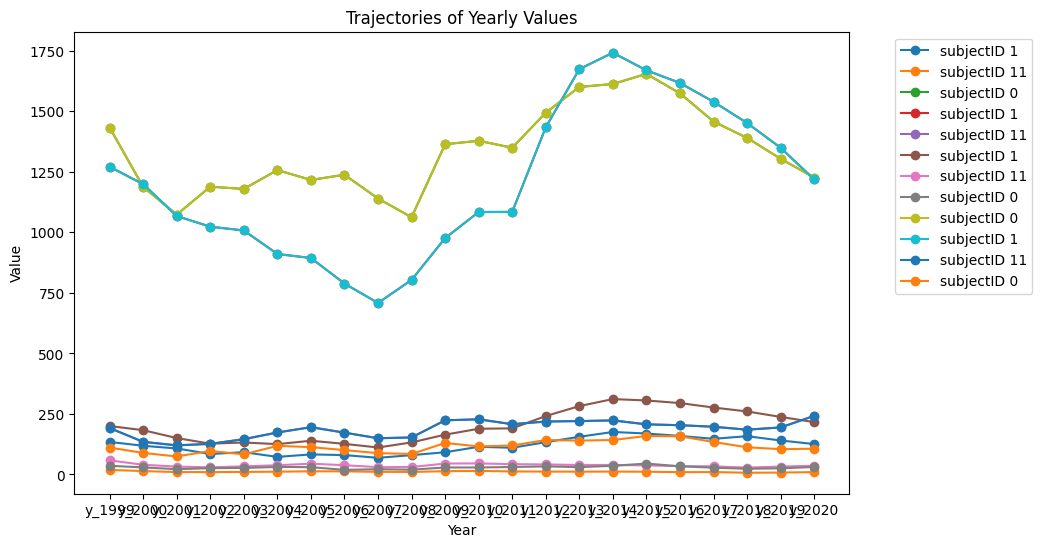

In [19]:
# Select columns that match the pattern 'y_XXXX'
yearly_columns = [col for col in df_filtered.columns if col.startswith('y_') and col[2:].isdigit()]

# Create a new DataFrame with only the yearly columns
df_yearly = df_filtered[yearly_columns]

# Plotting
plt.figure(figsize=(10, 6))

for index, row in df_yearly.iterrows():
    plt.plot(df_yearly.columns, row, marker='o', label=f'subjectID {df_filtered.loc[index, "subjectID"]}')

plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Trajectories of Yearly Values')

# Adjust the legend position to the right of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

**3rd** Display espon data for the different NUTS 

    id                                               name         code  \
0  299  Population - age group 25-64 - with educationa...  25-64_T_5-8   
1  299  Population - age group 25-64 - with educationa...  25-64_T_5-8   
2  299  Population - age group 25-64 - with educationa...  25-64_T_5-8   
3  299  Population - age group 25-64 - with educationa...  25-64_T_5-8   
4  299  Population - age group 25-64 - with educationa...  25-64_T_5-8   

  nomenclature  level  version tunit_code               tunit_name processes  \
0         NUTS      0     2016         AT               OSTERREICH       NaN   
1         NUTS      0     2016         BE          BELGIQUE-BELGIE       NaN   
2         NUTS      0     2016         BG                 BULGARIA       NaN   
3         NUTS      0     2016         CH  SCHWEIZ/SUISSE/SVIZZERA       NaN   
4         NUTS      0     2016         CY                   KYPROS       NaN   

                                             sources  ...  y_2012  y_2013 

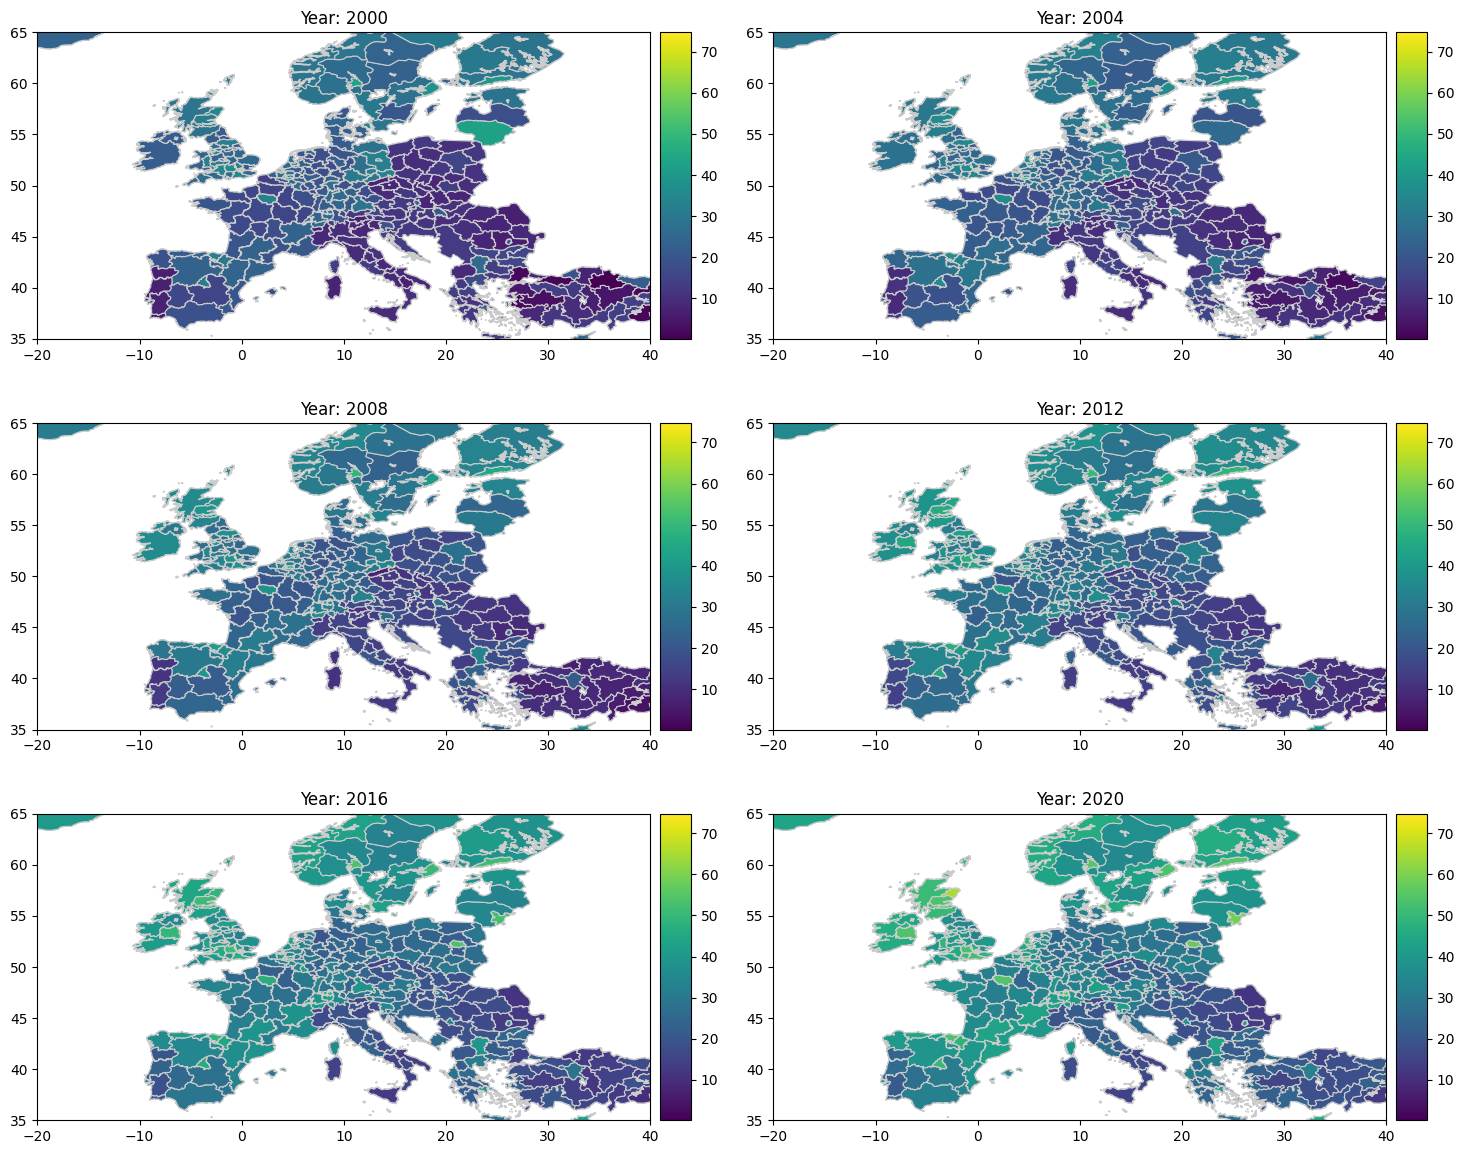

In [20]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Define file paths
filepath = "test_data\\espon\\Educational_attainment_level_by_age_group\\Population_-_age_group_25-64_-_with_educational_attainment_level_5-8_.csv"
geo_filepath = "test_data\\espon\\geometry.csv"

# Read the CSV files
geo_df = pd.read_csv(geo_filepath)
df = pd.read_csv(filepath)

# Convert the 'geometry' column from WKT to shapely geometries
geo_df['geometry'] = geo_df['geometry'].apply(wkt.loads)

# Merge the DataFrames on the 'tunit_code' column
merged_df = pd.merge(df, geo_df, on='tunit_code')

# Convert the merged DataFrame to a GeoPandas DataFrame
merged_df = gpd.GeoDataFrame(merged_df, geometry='geometry')

# Create a list of years to plot
years = [2002, 2008, 2014, 2020]
years = [2000, 2004, 2008, 2012, 2016, 2020]

# Calculate the min and max values for the 'x' column across all years
vmin = merged_df[[f'y_{year}' for year in years]].min().min()
vmax = merged_df[[f'y_{year}' for year in years]].max().max()

# Create a 2x2 subplot
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

print(merged_df.head())

# Plot each year in a separate subplot
for i, year in enumerate(years):
    ax = axes[i // 2, i % 2]
    merged_df['x'] = merged_df[f'y_{year}']
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    merged_df.plot(column='x', cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, cax=cax, vmin=vmin, vmax=vmax)
    ax.set_xlim(-20, 40)
    ax.set_ylim(35, 65)
    ax.set_title(f"Year: {year}")

# Adjust layout and reduce space between plots
plt.tight_layout(pad=2)
plt.show()

In [6]:
merged_df.columns

Index(['id', 'name', 'code', 'nomenclature', 'level', 'version', 'tunit_code',
       'tunit_name', 'processes', 'sources', 'y_2000', 'y_2001', 'y_2002',
       'y_2003', 'y_2004', 'y_2005', 'y_2006', 'y_2007', 'y_2008', 'y_2009',
       'y_2010', 'y_2011', 'y_2012', 'y_2013', 'y_2014', 'y_2015', 'y_2016',
       'y_2017', 'y_2018', 'y_2019', 'y_2020', 'geometry', 'x'],
      dtype='object')

#### geoTIFF
This example takes the topology map and displays the altitude profile of a track.

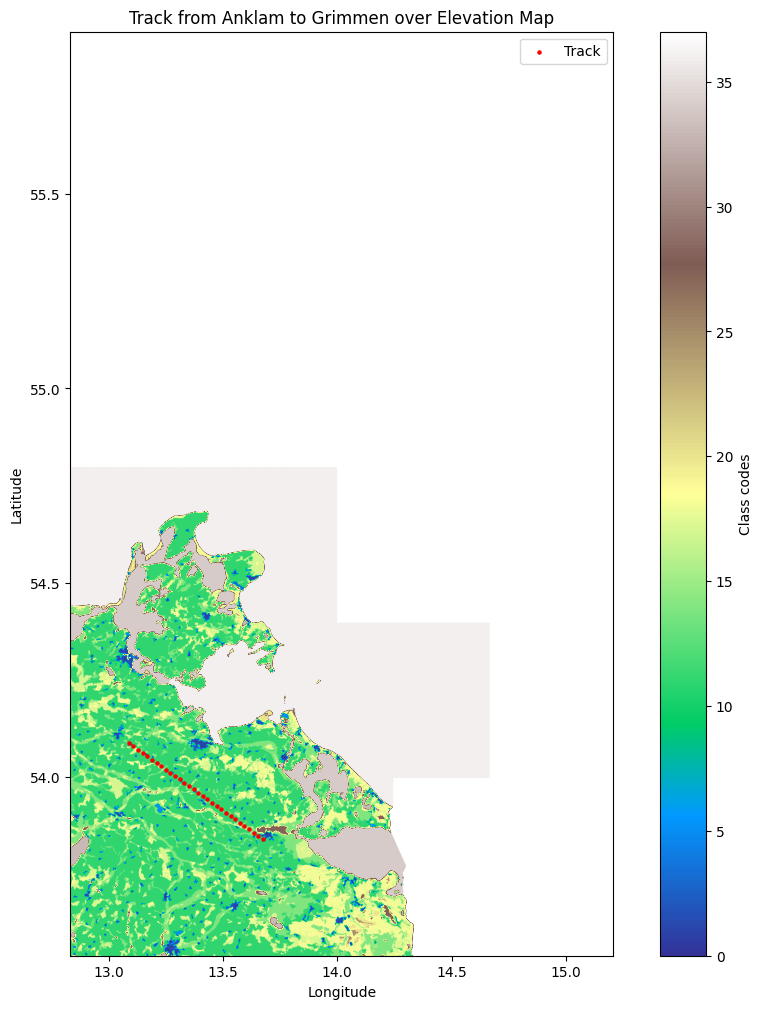

In [32]:
import rasterio
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import numpy as np

# Filepath for the GeoTIFF (Elevation Map)
elevation_file = 'test_data\\corine\\12.83_53.54_CORINE_LAND_COVER_1990_100x100_ETRS89.tif'

# Step 1: Load and plot the GeoTIFF
with rasterio.open(elevation_file) as src:
    elevation = src.read(1)
    transform = src.transform  # Transformation for plotting
    extent = (transform[2], transform[2] + transform[0] * src.width, 
              transform[5] + transform[4] * src.height, transform[5])

# Step 2: Create a track from Berlin to Madrid
anklam_coords = (53.84, 13.675)  # Berlin (latitude, longitude)
grimmen_coords = (54.0884, 13.0884)    # Madrid (latitude, longitude)
n_points = 30

# Interpolating latitudes and longitudes between Berlin and Madrid
latitudes = np.linspace(anklam_coords[0], grimmen_coords[0], n_points)
longitudes = np.linspace(anklam_coords[1], grimmen_coords[1], n_points)

# Create GeoDataFrame for the track
track_gdf = gpd.GeoDataFrame({
    'geometry': [Point(lon, lat) for lon, lat in zip(longitudes, latitudes)]
}, crs='EPSG:4326')

# Reproject the track GeoDataFrame to the GeoTIFF's CRS if necessary (assuming GeoTIFF is in EPSG:4326)
# Otherwise, uncomment the line below and change the CRS to the one from your GeoTIFF.
# track_gdf = track_gdf.to_crs(src.crs)

# Step 3: Plot both the GeoTIFF and the track
plt.figure(figsize=(12, 12))

# Plot the elevation map
plt.imshow(elevation, cmap='terrain', extent=extent)
plt.colorbar(label='Class codes')

# Overlay the track on the map
track_gdf.plot(ax=plt.gca(), marker='o', color='red', markersize=5, label='Track')

# Customize the plot
plt.title('Track from Anklam to Grimmen Corine')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Show the plot
plt.show()



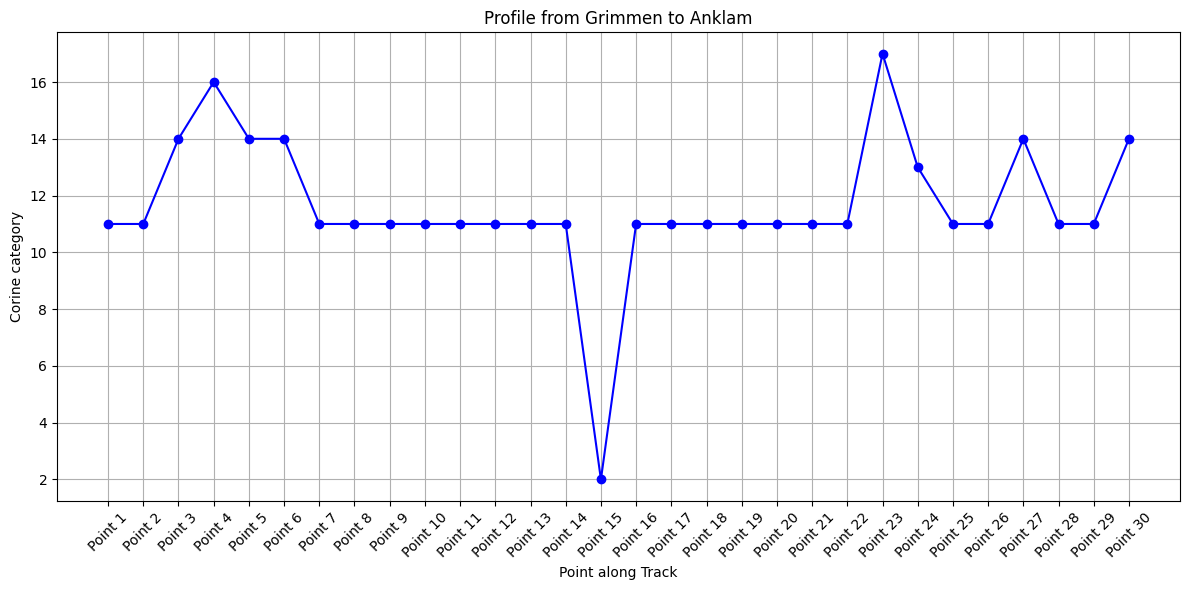

In [31]:
# Function to get elevation at given points
def get_elevation(track_points, transform, elevation_data):
    elevations = []
    for point in track_points:
        # Transform the point coordinates to pixel indices
        row, col = rasterio.transform.rowcol(transform, point.x, point.y)
        # Check if the indices are within the bounds of the elevation data
        if 0 <= row < elevation_data.shape[0] and 0 <= col < elevation_data.shape[1]:
            elevations.append(elevation_data[row, col] )
        else:
            elevations.append(np.nan)  # Assign NaN if out of bounds
    return elevations

# Get elevation values for the track
elevation_values = get_elevation(track_gdf.geometry, transform, elevation)

# Step 3: Plot the altitude profile
plt.figure(figsize=(12, 6))
plt.plot(np.arange(n_points), elevation_values, marker='o', linestyle='-', color='blue')
plt.title('Profile from Grimmen to Anklam')
plt.xlabel('Point along Track')
plt.ylabel('Corine category')
plt.xticks(ticks=np.arange(n_points), labels=[f'Point {i+1}' for i in range(n_points)], rotation=45)
plt.grid()
plt.tight_layout()
plt.show()